# SRE ReAct agent with custom schema and RAG (to store mitigation plans)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Generate structured diagnosis** with detailed reasoning and root cause analysis
- **Create mitigation plans** by leveraging ChromaDB RAG to search for similar past incidents
- **Provide comprehensive reports** with step-by-step remediation guidance

In [1]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [2]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [51]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.peek()

{'ids': ['a27c328e-b573-4463-a2b3-9c1bc32d58e6',
  '2a61957b-996e-493d-b186-5f5ccc82338b',
  '9b0fa74a-e2f9-4410-91c5-847b03e0e5e0'],
 'embeddings': array([[ 0.06704511, -0.02132846,  0.02176534, ..., -0.01533561,
         -0.07067233, -0.00742706],
        [ 0.06704511, -0.02132846,  0.02176534, ..., -0.01533561,
         -0.07067233, -0.00742706],
        [ 0.06478721,  0.00240931,  0.04798659, ..., -0.01987657,
         -0.02899614,  0.01351828]], shape=(3, 384)),
 'documents': ['# 📝 Results of the Analysis\n\n## 🔍 Steps Performed\n- Used kubectl_get to run \'kubectl get pods --all-namespaces -o wide\' to list pod statuses and details.\n- Ran kubectl_describe on pod \'geo\' in namespace \'test-hotel-reservation\' to inspect container state, exit code, and events.\n- Fetched the container logs using kubectl_logs for pod geo-6b4b89b5f5-v44q4 (container hotel-reserv-geo) in namespace test-hotel-reservation (tail=500).\n- Ran kubectl_get to list pods in namespace test-hotel-reservation 

## Building SRE ReAct agent

In [4]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [5]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

prometheus_URL = os.environ.get("PROMETHEUS_SERVER_URL")

client = MultiServerMCPClient(
    {
        "kubernetes" : { # https://github.com/Flux159/mcp-server-kubernetes
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": { # https://github.com/chroma-core/chroma-mcp
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        },
        "prometheus": {
            "command": "npx",
            "args": ["prometheus-mcp@latest", "stdio"],
            "transport": "stdio",
            "env": {
                "PROMETHEUS_URL": str(prometheus_URL)
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [134]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents
🔧 prometheus_list_metrics
🔧 prometheus_metric_metadata
🔧 prometheus_list_labels
🔧 prometheus_label_values
🔧 prometheus_list_targets
🔧 prometheus_scrape_pool_targets
🔧 prometheus_runtime_info
🔧 prometheus_build_info
🔧 prometheus_query
🔧 prometheus_query_range


In [6]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

k8s_tools = []
chroma_tools = []
prometheus_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        k8s_tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)
    # Create a custom list of Prometheus tools
    elif "prometheus" in tool.name:
        prometheus_tools.append(tool)
    

In [7]:
# List of kubernetes tools
for tool in k8s_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [8]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [9]:
# List of prometheus tools
for tool in prometheus_tools:
    print(f"🔧 {tool.name} : {tool.description}")

🔧 prometheus_list_metrics : List all available Prometheus metrics
🔧 prometheus_metric_metadata : Get metadata for a specific Prometheus metric
🔧 prometheus_list_labels : List all available Prometheus labels
🔧 prometheus_label_values : Get all values for a specific Prometheus label
🔧 prometheus_list_targets : List all Prometheus targets
🔧 prometheus_scrape_pool_targets : Get targets for a specific scrape pool
🔧 prometheus_runtime_info : Get Prometheus runtime information
🔧 prometheus_build_info : Get Prometheus build information
🔧 prometheus_query : Execute a Prometheus query
🔧 prometheus_query_range : Execute a Prometheus range query


In [10]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    is_already_happened: bool

In [12]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster and prometheus server.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl and prometheus tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [13]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [14]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

### Extract insights node

In [15]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [ ]:
llm_with_struct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [ ]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_struct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [26]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
sre_agent_tools = k8s_tools + prometheus_tools + [completion_tool]

In [27]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(sre_agent_tools, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [31]:
sre_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [32]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [33]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [34]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [35]:
mitigation_agent_tools = k8s_tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [36]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "is_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

In [37]:
async def store_incident_report(state: SREAgentState):
    """Store the incident report with the mitigation plan in chromaDB incidents collection"""

    from chromadb import PersistentClient
    import uuid

    chroma_client = PersistentClient(path=chromaDB_path)

    incidents_collection = chroma_client.get_or_create_collection("incidents")

    incidents_collection.add(
        ids=[str(uuid.uuid4())],
        documents=state["final_output"],
    )

    return {}

### Assemble the graph

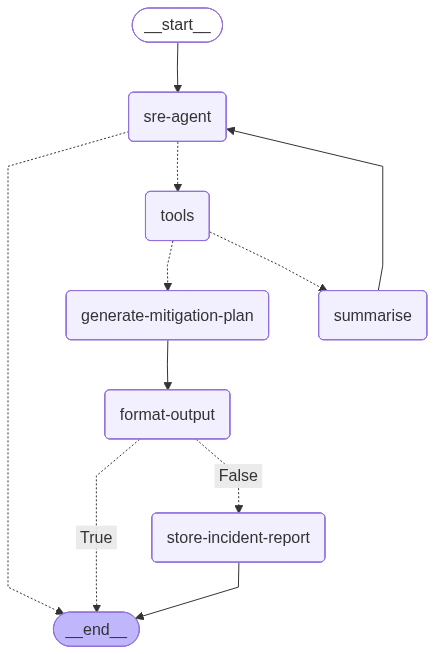

In [64]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(sre_agent_tools)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)
builder.add_node("store-incident-report", store_incident_report)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# If is a new incident, store in VectorDB
def is_already_happened(state: SREAgentState):
    return bool(state['is_already_happened'])
    
builder.add_conditional_edges(
    "format-output",
    is_already_happened,
    {
        True: END,
        False: "store-incident-report"
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)
builder.add_edge("store-incident-report", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [65]:
from datetime import datetime

def save_markdown_file(structured_result, trace_name):
    
    # Get the output path from environment variable
    output_path = os.getenv("RESULTS_PATH")
    if not output_path:
        raise ValueError("Environment variable not set")
    

    # Generate timestamp for filename and title
    now = datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    title_timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    # Create filename
    filename = f"{filename_timestamp}.md"
    filepath = output_path + "/" + filename
    
    # Get markdown content
    markdown_content = structured_result.get("final_output", "")
    
    # Create the complete file content with title header
    file_content = f"""# {title_timestamp} - {trace_name}

    {markdown_content}"""
    
    # Write to file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(file_content)
    
    print(f"Markdown file saved: {filepath}")
    return str(filepath)

In [66]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "is_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    save_markdown_file(result, trace_name)

    return result

In [43]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [58]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [67]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Markdown file saved: /Users/martinimarcello00/github-sync/SRE-agent/results/2025-08-28_11-31-26.md


In [123]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Ran kubectl_get to list pods across all namespaces (kubectl get pods --all-namespaces -o wide).
- Executed kubectl_get to list pods in namespace 'test-hotel-reservation' with wide output (kubectl get pods -n test-hotel-reservation -o wide).
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to retrieve container state, termination exit code, and recent events.
- Ran kubectl_logs for pod 'geo' in namespace 'test-hotel-reservation' (tail=200); tool error: Resource pod geo not found.
- Ran kubectl_get (pods --all-namespaces -o wide) to list pods; observed geo-6b4b89b5f5-w8vtg in CrashLoopBackOff with 9 restarts.
- Fetched logs with kubectl_logs for pod geo-6b4b89b5f5-w8vtg in namespace test-hotel-reservation (tail=500).
- Ran kubectl_get (pods -n test-hotel-reservation -o wide) to list pods; saw geo-6b4b89b5f5-w8vtg in CrashLoopBackOff (9 restarts) and mongodb-geo-5ff578bcb8-wssnt in Running state.
- Ran kubectl_get for Service resources in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o yaml).
- Queried the Service resource for mongodb-geo in namespace test-hotel-reservation using kubectl_get (output: yaml).
- Ran kubectl_get to list pods in namespace 'test-hotel-reservation' with wide output (kubectl get pods -n test-hotel-reservation -o wide).
- Ran prometheus_query with increase(kube_pod_container_status_restarts_total{namespace="test-hotel-reservation", pod="geo-6b4b89b5f5-w8vtg"}[1h]) — result: empty vector.
- Ran kubectl_get on pods in namespace 'test-hotel-reservation' with wide output to check current pod statuses.
- Executed prometheus_query for kube_pod_container_status_restarts_total{namespace="test-hotel-reservation", pod="geo-6b4b89b5f5-w8vtg"}; received empty result.

## 💡 Insights Gathered
- Pod 'geo' in namespace 'test-hotel-reservation' is in CrashLoopBackOff (0/1) with 9 restarts (last ~2m ago) — a likely cause of service failures for the geo component.
- Pod 'geo' in namespace 'test-hotel-reservation' is in CrashLoopBackOff (0/1) with 9 restarts (last restart ~2m ago), indicating the geo component is repeatedly failing and likely causing service disruption.
- kubectl describe shows the container 'hotel-reserv-geo' in CrashLoopBackOff with Restart Count 9 and last termination Exit Code 2 — the image was successfully pulled, so this is a runtime/application crash (not an image-pull issue).
- Attempt to fetch logs from pod 'geo' in namespace 'test-hotel-reservation' failed: kubectl_logs returned "Resource pod geo not found" — logs unavailable (pod may have been deleted/renamed or there is a namespace/context mismatch).
- kubectl_get --all-namespaces -o wide reveals the geo pod’s full name is geo-6b4b89b5f5-w8vtg in namespace test-hotel-reservation and it is in CrashLoopBackOff (0/1) with 9 restarts — this explains the earlier “pod geo not found” error (the short name used for logs was incorrect).
- The geo pod is crashing because it cannot connect to its MongoDB backend: logs show it reads DB URL mongodb-geo:27777 then errors with "no reachable servers" and panics, causing the CrashLoopBackOff.
- The mongodb-geo pod (mongodb-geo-5ff578bcb8-wssnt) is Running in the test-hotel-reservation namespace — the MongoDB backend appears healthy, so geo’s “no reachable servers” error is likely due to networking/DNS, wrong port, or auth/connection-string mismatch rather than MongoDB being down.
- The mongodb-geo Service exists and exposes port 27017 (targetPort 27017) in namespace test-hotel-reservation — but geo’s logs show it tries to connect to mongodb-geo:27777. This port mismatch likely explains the “no reachable servers” error and the geo pod CrashLoopBackOff.
- The mongodb-geo Service is defined with port 27017 (targetPort 27017, ClusterIP 10.96.15.217); geo is attempting to connect to mongodb-geo:27777 — a clear port mismatch that likely causes the “no reachable servers” error and geo CrashLoopBackOff.
- kubectl get pods -n test-hotel-reservation -o wide confirms geo-6b4b89b5f5-w8vtg is in CrashLoopBackOff (0/1) with 9 restarts (last ~4m24s) while mongodb-geo-5ff578bcb8-wssnt is Running — reinforcing that geo’s crashes are due to configuration/networking (e.g., the previously observed port mismatch) rather than MongoDB being down.
- Prometheus query for restart increases (increase(kube_pod_container_status_restarts_total{namespace="test-hotel-reservation", pod="geo-6b4b89b5f5-w8vtg"}[1h])) returned no data — indicating Prometheus has no matching metric for that pod/time window (possible label mismatch or scrape gap), so restart counts cannot be confirmed from metrics.
- Pod geo-6b4b89b5f5-w8vtg is now in Running (1/1) with 10 restarts (last restart ~5m19s ago) — it recently recovered from CrashLoopBackOff but has experienced repeated restarts, so instability may persist.
- Prometheus query for kube_pod_container_status_restarts_total for pod geo-6b4b89b5f5-w8vtg returned an empty vector — there are no matching restart metrics (indicating a monitoring/label/scrape gap).

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo service (pod geo-6b4b89b5f5-w8vtg in namespace test-hotel-reservation) is repeatedly crashing (CrashLoopBackOff) because it cannot connect to its MongoDB backend due to a port mismatch: the geo container attempts to connect to mongodb-geo:27777, while the mongodb-geo Service exposes port 27017 (targetPort 27017). This causes connection errors ("no reachable servers") and application panics/exit code 2, triggering repeated restarts and instability.

Reasoning:
Observed evidence and reasoning:

- Pod state: kubectl describe and get showed pod geo-6b4b89b5f5-w8vtg in CrashLoopBackOff with Restart Count 9 (later 10) and last termination Exit Code 2 — indicates an application/runtime crash rather than image-pull.
- Logs: geo pod logs indicate it reads DB URL "mongodb-geo:27777" and then errors with "no reachable servers" and panics. That is a clear connection failure to MongoDB.
- MongoDB service/pod health: mongodb-geo pod (mongodb-geo-5ff578bcb8-wssnt) is Running. The mongodb-geo Service exists with ClusterIP 10.96.15.217 and port 27017 (targetPort 27017). Since the DB pod is running and the Service exposes 27017, the geo pod should connect on 27017.
- Port mismatch: geo is attempting to reach port 27777 while the Service listens on 27017 — this mismatch will cause connection attempts to fail with "no reachable servers" even though MongoDB is healthy and reachable on the correct port.
- Prometheus telemetry: prometheus queries for kube_pod_container_status_restarts_total{namespace="test-hotel-reservation", pod="geo-6b4b89b5f5-w8vtg"} and increase(...) returned empty vectors — indicating a monitoring/scrape/label mismatch (no restart metric available), so restart counts could not be validated from metrics but were visible via kubectl.

Conclusion: The root cause is a configuration error (wrong MongoDB port in the geo component) causing connection failures and CrashLoopBackOff. The monitoring gap (missing Prometheus restart metric) is a secondary observation but not the cause of the crash.

## 🛠️ Mitigation Plan Strategy
The geo pod crashes because it tries to reach mongodb-geo:27777 while the MongoDB Service listens on 27017. Fix the mismatch by updating geo to use port 27017 (preferred) or temporarily patch the Service to 27777 (workaround), then verify rollout, run connectivity checks, revert any temporary changes, and apply persistent fixes in source-of-truth and CI.

## 📋 Detailed Mitigation Steps
1. 1) Confirm current state (read-only): kubectl -n test-hotel-reservation get pods; kubectl -n test-hotel-reservation describe pod geo-6b4b89b5f5-w8vtg; kubectl -n test-hotel-reservation logs geo-6b4b89b5f5-w8vtg -c hotel-reserv-geo --tail=200; kubectl -n test-hotel-reservation get svc mongodb-geo -o yaml.
2. 2) Locate the 27777 setting: inspect geo Deployment, ConfigMaps and Secrets for the DB port (kubectl -n test-hotel-reservation get deployment geo -o yaml; kubectl -n test-hotel-reservation get configmap,secret -o yaml | grep -n "27777" || true).
3. 3) Recommended fix (preferred): update geo config to use port 27017 where the DB actually listens. If environment var: kubectl -n test-hotel-reservation set env deployment/geo MONGO_PORT=27017 or edit the Deployment/ConfigMap in the source-of-truth (Helm/GitOps) and redeploy.
4. 4) Force rollout and verify: kubectl -n test-hotel-reservation rollout restart deployment geo; kubectl -n test-hotel-reservation rollout status deployment/geo; kubectl -n test-hotel-reservation get pods -l app=geo; kubectl -n test-hotel-reservation logs <new-geo-pod> -c hotel-reserv-geo --tail=200 to confirm successful Mongo connection and no panic.
5. 5) Optional in-cluster connectivity test: kubectl -n test-hotel-reservation run --rm -it test-net --image=nicolaka/netshoot --restart=Never -- /bin/bash; inside: nc -vz mongodb-geo 27017 or mongo --host mongodb-geo --port 27017 --eval 'db.runCommand({ping:1})'.
6. 6) Temporary workaround (if you cannot change geo config quickly): patch the mongodb-geo Service port to 27777 (short-lived): kubectl -n test-hotel-reservation patch svc mongodb-geo --type='json' -p='[{"op":"replace","path":"/spec/ports/0/port","value":27777}]' or kubectl -n test-hotel-reservation edit svc mongodb-geo. Verify geo becomes Ready. Revert this workaround as soon as config is fixed.
7. 7) Rollback plan: if the deployment change causes regression, kubectl -n test-hotel-reservation rollout undo deployment/geo. If Service was patched, revert port to 27017 via patch/edit.
8. 8) If issue persists, gather diagnostics: kubectl -n test-hotel-reservation logs <geo-pod> --previous -c hotel-reserv-geo; kubectl -n test-hotel-reservation describe pod <geo-pod>; kubectl -n test-hotel-reservation get events --sort-by='.lastTimestamp'; kubectl -n test-hotel-reservation get endpoints mongodb-geo -o yaml; kubectl -n test-hotel-reservation exec -it <mongodb-pod> -- ss -ltnp | grep 27017.
9. 9) Post-remediation validation & cleanup: ensure geo pods are Running and Ready; run application smoke tests; if temporary Service patch was applied, revert it and confirm geo remains functional; commit fixes to Helm/Git repo so the change is permanent.
10. 10) Follow-up and prevention: centralize DB connection settings (ConfigMap/Secret/Helm values), add startup retry/backoff and improved readiness checks in geo, add CI tests to validate host:port connectivity in staging, and add alerts for CrashLoopBackOff correlated with DB connection errors.
11. 11) Artifacts to attach to incident record: pre/post-change YAMLs for Deployment geo, ConfigMap/Secrets, and Service mongodb-geo; geo pod logs pre/post-change; kubectl describe outputs; endpoints and events.


## Analysis of the experiment

In [110]:
from langchain_core.messages import AIMessage

for i, msg in enumerate(structured_result['messages']):
    if isinstance(msg, AIMessage):
        print(f'{i}) {msg.additional_kwargs["tool_calls"][0]["function"]["name"]}') 

0) kubectl_get
2) kubectl_get
4) kubectl_describe
6) kubectl_logs
8) kubectl_get
10) kubectl_logs
12) kubectl_get
14) kubectl_get
16) kubectl_get
18) kubectl_get
20) prometheus_query
22) kubectl_get
24) prometheus_query
26) submit_final_diagnosis


In [112]:
structured_result['messages'][24].additional_kwargs["tool_calls"][0]

{'id': 'call_vF1ERPb0HavTrp4rH5TQgTWy',
 'function': {'arguments': '{"query":"kube_pod_container_status_restarts_total{namespace=\\"test-hotel-reservation\\", pod=\\"geo-6b4b89b5f5-w8vtg\\"}"}',
  'name': 'prometheus_query'},
 'type': 'function'}

In [113]:
structured_result['messages'][25]

ToolMessage(content='{"resultType":"vector","result":[]}', name='prometheus_query', id='110dceef-a32f-4cad-9043-f85f64078436', tool_call_id='call_vF1ERPb0HavTrp4rH5TQgTWy')

In [114]:
from langchain_core.messages import AIMessage
import matplotlib.pyplot as plt
from collections import Counter

def count_tool_calls(messages):
    """
    Plots a bar chart of tool call occurrences by tool name from state['messages'].
    """
    # Extract tool names from ToolMessage objects
    tool_calls = []
    for msg in messages:

        if isinstance(msg, AIMessage):
            if hasattr(msg, 'additional_kwargs'):
                if "tool_calls" in msg.additional_kwargs:
                    for call in msg.additional_kwargs['tool_calls']:
                        if "function" in call:
                            if "name" in call["function"]:
                                tool_calls.append(call["function"]["name"])

    # Count occurrences
    counts = Counter(tool_calls)

    return dict(counts)

In [115]:
tool_calls = count_tool_calls(structured_result["messages"])
tool_calls

{'kubectl_get': 8,
 'kubectl_describe': 1,
 'kubectl_logs': 2,
 'prometheus_query': 2,
 'submit_final_diagnosis': 1}

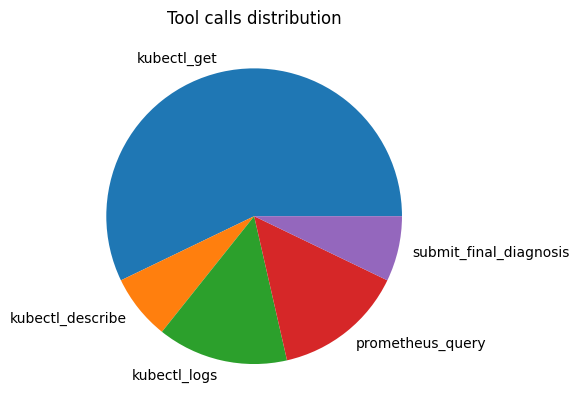

In [122]:
plt.pie(list(tool_calls.values()), labels=list(tool_calls.keys()))
plt.title('Tool calls distribution')
plt.show()

In [48]:
for step in structured_result["prev_steps"]:
    print(step)

Called kubectl_get to list pods across all namespaces (kubectl get pods --all-namespaces).
Ran kubectl_get to list pods across all namespaces with wide output (equivalent to: kubectl get pods --all-namespaces -o wide).
Ran kubectl_describe on pod geo-6b4b89b5f5-w8vtg in namespace test-hotel-reservation.
Fetched the last 200 lines of logs from pod test-hotel-reservation/geo-6b4b89b5f5-w8vtg (container: hotel-reserv-geo) using kubectl_logs.
Ran kubectl_get to list pods in namespace test-hotel-reservation with wide output (kubectl get pods -n test-hotel-reservation -o wide).
Ran kubectl_get for services in namespace test-hotel-reservation with wide output (kubectl get services -n test-hotel-reservation -o wide).


In [49]:
for insight in structured_result["insights"]:
    print(insight)

kubectl get pods across all namespaces shows almost all pods in Running state (one Succeeded job); no Pending, CrashLoopBackOff, or Failed pods observed — control-plane and application pods (test-hotel-reservation) appear healthy.
The test-hotel-reservation geo pod (geo-6b4b89b5f5-w8vtg) is in CrashLoopBackOff with 5 restarts — a failing geo service is likely causing errors for that component.
Pod test-hotel-reservation/geo-6b4b89b5f5-w8vtg is in CrashLoopBackOff: container 'hotel-reserv-geo' repeatedly starts then terminates with Exit Code 2 (RestartCount=5). Image yinfangchen/geo:app3 was pulled successfully and kubelet events show Back-off restarting — indicates the application process is failing on startup (not an image pull or OOM issue).
The geo service fails at startup because it cannot reach the MongoDB instance (Read database URL: mongodb-geo:27777) — logs show “no reachable servers” and a panic, which explains the CrashLoopBackOff.
The mongodb-geo pod is Running (IP 10.244.1.

In [50]:
print(structured_result["response"])

Diagnosis:
The geo service is crashing because it tries to connect to MongoDB at mongodb-geo:27777 but the MongoDB Service (and pod) are listening on the default port 27017. The port mismatch causes connection failures (“no reachable servers”), a panic on start, and CrashLoopBackOff.

Reasoning:
Investigation steps and evidence:

- Cluster pod summary showed the geo pod (test-hotel-reservation/geo-6b4b89b5f5-w8vtg) in CrashLoopBackOff with RestartCount=5. Other pods (including mongodb-geo) are Running.
- Describing the geo pod and container events showed repeated starts followed by termination with Exit Code 2 and kubelet Back-off restarting — indicating the application process is failing at startup rather than image pull or OOM.
- Logs from the geo container show it reads the DB URL as: mongodb-geo:27777 and then errors with “no reachable servers” followed by a panic. This explains the exit code and restart loop.
- The mongodb-geo pod is Running (has an IP) and the mongodb-geo Service

In [70]:
print(structured_result["mitigation_plan_overview"])

The geo pod crashes because it tries to reach mongodb-geo:27777 while the MongoDB Service listens on 27017. Fix the mismatch by updating geo to use port 27017 (preferred) or temporarily patch the Service to 27777 (workaround), then verify rollout, run connectivity checks, revert any temporary changes, and apply persistent fixes in source-of-truth and CI.


In [71]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_pgf2rbXmO7uQq2CL7rdxSLEU)
 Call ID: call_pgf2rbXmO7uQq2CL7rdxSLEU
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS       AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-774s7                                             0/1     Completed          0              27m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-lmr82                                   1/1     Running            0              36m   10.244.0.2    kind-control-plane   <none>           <none>
kube-system              coredns-